## Эксперименты с разными способами заполнения изображений и генерации признаков Харалика #

Загрузка csv с признаками Харалика

In [ ]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    # "D:/pcapTest/haralik/Normal/Spiral/haralick_135.csv",
    # "D:/pcapTest/haralik/Normal/Spiral/6_haralick_135.csv",
    # "D:/pcapTest/haralik/Normal/Spiral/14_haralick_135.csv",
    "D:/pcapTest/SWaT Dataset/normal_haralicks.csv"
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    dfh = pd.read_csv(filepath)
    dfs_normal.append(dfh)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)

filepaths_attack = [
    # "D:/pcapTest/haralik/Atack1/Spiral/2_haralick_135.csv",
    # "D:/pcapTest/haralik/Atack1/Spiral/3_haralick_135.csv",
    # "D:/pcapTest/haralik/Atack2/Spiral/10_haralick_135.csv",
    "D:/pcapTest/SWaT Dataset/abnormal_haralicks.csv"
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    dfh = pd.read_csv(filepath)
    dfs_attack.append(dfh)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)

Загрузка картинок

In [ ]:
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10':
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
data, problematic_files = load_images_from_directories(images_dir, "Spiral", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце

Разделение на тренировочную и тестовую выборки

In [ ]:
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
   df, test_size=0.2, random_state=42
)

Объединение изображений с соответствующими признаками Харалика

In [ ]:
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)

Отделяем метки и удаляем ненужные столбцы

In [ ]:
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)

Кодируем метки в числа

In [ ]:
import numpy as np
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)

In [ ]:
train_labels
counts = np.bincount(train_labels)
print(counts[0], counts[1])

Код модели с запуском обучения и выводом результатов метрик

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor0_sp=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor0_sp.history)

### Аналогичные запуски модели на других данных: ##

Spiral 0:

In [93]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Spiral/haralick_0.csv",
    "D:/pcapTest/haralik/Normal/Spiral/6_haralick_0.csv",
    "D:/pcapTest/haralik/Normal/Spiral/14_haralick_0.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Spiral/2_haralick_0.csv",
    "D:/pcapTest/haralik/Atack1/Spiral/3_haralick_0.csv",
    "D:/pcapTest/haralik/Atack2/Spiral/10_haralick_0.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Spiral", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor0_sp=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor0_sp.history)

Problematic files: []
{'loss': [3.6064672470092773, 0.26723048090934753, 0.13835537433624268, 0.11125455051660538, 0.09572044014930725, 0.08710750192403793, 0.07727804780006409, 0.07000778615474701, 0.06264393776655197, 0.06049662455916405], 'accuracy': [0.7872806787490845, 0.8911891579627991, 0.9308985471725464, 0.9425320625305176, 0.9512825608253479, 0.9555988907814026, 0.9620615839958191, 0.9654711484909058, 0.9694516062736511, 0.9706249833106995], 'precision_8': [0.7908611297607422, 0.8934226632118225, 0.9187138676643372, 0.9347201585769653, 0.9303504824638367, 0.9447869658470154, 0.983005940914154, 0.9831623435020447, 0.9577828049659729, 0.9553249478340149], 'recall_8': [0.7908629775047302, 0.8925104141235352, 0.9480011463165283, 0.9535973072052002, 0.9773754477500916, 0.9693407416343689, 0.9416801333427429, 0.9483463168144226, 0.9832725524902344, 0.988463819026947], 'val_loss': [0.25770303606987, 0.1610203981399536, 0.11391498893499374, 0.10433237254619598, 0.08597109466791153, 0

Spiral45:

In [94]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Spiral/haralick_45.csv",
    "D:/pcapTest/haralik/Normal/Spiral/6_haralick_45.csv",
    "D:/pcapTest/haralik/Normal/Spiral/14_haralick_45.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Spiral/2_haralick_45.csv",
    "D:/pcapTest/haralik/Atack1/Spiral/3_haralick_45.csv",
    "D:/pcapTest/haralik/Atack2/Spiral/10_haralick_45.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Spiral", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor45_sp=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor45_sp.history)

Problematic files: []
{'loss': [3.556274890899658, 0.29817116260528564, 0.12545499205589294, 0.10174619406461716, 0.08749706298112869, 0.07844375818967819, 0.07321564853191376, 0.06861751526594162, 0.06558114290237427, 0.06164924427866936], 'accuracy': [0.7868543267250061, 0.9068371653556824, 0.9375998973846436, 0.9467682242393494, 0.9534398317337036, 0.9574233293533325, 0.9603531360626221, 0.9637973308563232, 0.9657493233680725, 0.9697990417480469], 'precision_9': [0.7906126976013184, 0.9075800180435181, 0.918659508228302, 0.922107994556427, 0.9290198683738708, 0.9510036706924438, 0.9726747870445251, 0.9877546429634094, 0.9887330532073975, 0.9881730675697327], 'recall_9': [0.7901500463485718, 0.9094182252883911, 0.9625253081321716, 0.9779367446899414, 0.9835973381996155, 0.9660518169403076, 0.9486926198005676, 0.9404727816581726, 0.9434022307395935, 0.9520089626312256], 'val_loss': [0.9929280877113342, 0.13611362874507904, 0.10847144573926926, 0.1042034775018692, 0.08349628746509552, 

Spiral90:

In [95]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Spiral/haralick_90.csv",
    "D:/pcapTest/haralik/Normal/Spiral/6_haralick_90.csv",
    "D:/pcapTest/haralik/Normal/Spiral/14_haralick_90.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Spiral/2_haralick_90.csv",
    "D:/pcapTest/haralik/Atack1/Spiral/3_haralick_90.csv",
    "D:/pcapTest/haralik/Atack2/Spiral/10_haralick_90.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Spiral", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor90_sp=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor90_sp.history)

Problematic files: []
{'loss': [2.9932780265808105, 0.22858519852161407, 0.11211548745632172, 0.09399119764566422, 0.08428139984607697, 0.07507199794054031, 0.06775267422199249, 0.061206020414829254, 0.056609198451042175, 0.05447158217430115], 'accuracy': [0.7935854196548462, 0.9128437042236328, 0.9444597363471985, 0.9519718885421753, 0.9570789933204651, 0.9630503058433533, 0.968481719493866, 0.9736562371253967, 0.9765046238899231, 0.9782847166061401], 'precision_10': [0.7972332835197449, 0.9095578789710999, 0.9554678201675415, 0.9742393493652344, 0.9791358113288879, 0.981650173664093, 0.9829952120780945, 0.9834127426147461, 0.9852519035339355, 0.987130343914032], 'recall_10': [0.7967696189880371, 0.9201136827468872, 0.9343369007110596, 0.9301559329032898, 0.9355382919311523, 0.9450096487998962, 0.9545371532440186, 0.9644671082496643, 0.968294620513916, 0.9699462056159973], 'val_loss': [0.22866268455982208, 0.13003112375736237, 0.10344681888818741, 0.08113736659288406, 0.08360996842384

Hilbert0:

In [96]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Hilbert/haralick_0.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/6_haralick_0.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/14_haralick_0.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Hilbert/2_haralick_0.csv",
    "D:/pcapTest/haralik/Atack1/Hilbert/3_haralick_0.csv",
    "D:/pcapTest/haralik/Atack2/Hilbert/10_haralick_0.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Hilbert", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor0_hb=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor0_hb.history)

Problematic files: []
{'loss': [3.6136035919189453, 0.8146475553512573, 0.670668363571167, 0.6706172823905945, 0.6706162691116333, 0.6706145405769348, 0.6706149578094482, 0.670619010925293, 0.6706197261810303, 0.6706215143203735], 'accuracy': [0.515888512134552, 0.5171201825141907, 0.5236672759056091, 0.523537278175354, 0.5236933827400208, 0.5236284136772156, 0.5236217379570007, 0.5235676765441895, 0.5236241221427917, 0.5236478447914124], 'precision_11': [0.5240594148635864, 0.5290911793708801, 0.9535090327262878, 0.8305811882019043, 0.9351270794868469, 0.9419779777526855, 0.871184229850769, 0.8845852017402649, 0.9128172397613525, 0.9107469320297241], 'recall_11': [0.5236043930053711, 0.459220290184021, 0.06662088632583618, 0.07929039001464844, 0.06815188378095627, 0.0674508735537529, 0.07426390796899796, 0.07265648990869522, 0.06997068226337433, 0.07021550089120865], 'val_loss': [1.1650906801223755, 0.6706639528274536, 0.6706939935684204, 0.6706749796867371, 0.6706806421279907, 0.6706

Hilbert45:

In [97]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Hilbert/haralick_45.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/6_haralick_45.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/14_haralick_45.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Hilbert/2_haralick_45.csv",
    "D:/pcapTest/haralik/Atack1/Hilbert/3_haralick_45.csv",
    "D:/pcapTest/haralik/Atack2/Hilbert/10_haralick_45.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Hilbert", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor45_hb=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor45_hb.history)

Problematic files: []
{'loss': [2.371760129928589, 0.5617504119873047, 0.3522868752479553, 0.3493541181087494, 0.34912917017936707, 0.34932637214660645, 0.34909963607788086, 0.3489209711551666, 0.3488474190235138, 0.34903544187545776], 'accuracy': [0.5157901048660278, 0.6530491709709167, 0.7470908761024475, 0.7482618093490601, 0.7491521835327148, 0.7487573623657227, 0.7489954829216003, 0.748672366142273, 0.7487913966178894, 0.7486632466316223], 'precision_12': [0.5239807367324829, 0.6597180962562561, 0.769983172416687, 0.7775281071662903, 0.7713906168937683, 0.7666298747062683, 0.7601721882820129, 0.7775760889053345, 0.7786292433738708, 0.7714052200317383], 'recall_12': [0.5231291055679321, 0.656298041343689, 0.7168379426002502, 0.7074083685874939, 0.7201841473579407, 0.7274032235145569, 0.7398625612258911, 0.7084604501724243, 0.7070656418800354, 0.7187928557395935], 'val_loss': [0.6945422887802124, 0.34829121828079224, 0.3485841155052185, 0.348153680562973, 0.3482063412666321, 0.34821

Hilbert90:

In [98]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Hilbert/haralick_90.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/6_haralick_90.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/14_haralick_90.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Hilbert/2_haralick_90.csv",
    "D:/pcapTest/haralik/Atack1/Hilbert/3_haralick_90.csv",
    "D:/pcapTest/haralik/Atack2/Hilbert/10_haralick_90.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Hilbert", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor90_hb=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor90_hb.history)

Problematic files: []
{'loss': [5.877642631530762, 1.0001498460769653, 0.7032296657562256, 0.693012535572052, 0.6930255889892578, 0.6930080652236938, 0.6930082440376282, 0.6930105090141296, 0.6930069923400879, 0.6930062770843506], 'accuracy': [0.5157986283302307, 0.5161029100418091, 0.5148924589157104, 0.5085433721542358, 0.5085251927375793, 0.5084814429283142, 0.5085117816925049, 0.5084583759307861, 0.5084425806999207, 0.5085020661354065], 'precision_13': [0.5239801406860352, 0.5244397521018982, 0.5200805068016052, 0.5085821747779846, 0.5085513591766357, 0.5085601210594177, 0.5085556507110596, 0.5085381865501404, 0.5085774660110474, 0.5085721611976624], 'recall_13': [0.5233237743377686, 0.5203525424003601, 0.5972294211387634, 0.996580958366394, 0.9990469813346863, 0.9954882264137268, 0.997772753238678, 0.996650218963623, 0.9912463426589966, 0.9953174591064453], 'val_loss': [3.290041208267212, 0.7108146548271179, 0.6930263042449951, 0.6930110454559326, 0.693055272102356, 0.693013548851

Hilbert135

In [99]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/Hilbert/haralick_135.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/6_haralick_135.csv",
    "D:/pcapTest/haralik/Normal/Hilbert/14_haralick_135.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/Hilbert/2_haralick_135.csv",
    "D:/pcapTest/haralik/Atack1/Hilbert/3_haralick_135.csv",
    "D:/pcapTest/haralik/Atack2/Hilbert/10_haralick_135.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "Hilbert", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor135_hb=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor135_hb.history)

Problematic files: []
{'loss': [4.1475372314453125, 0.8553797006607056, 0.6853442788124084, 0.6930139064788818, 0.6930080056190491, 0.6930027008056641, 0.6930084824562073, 0.6930065751075745, 0.6930084824562073, 0.6930091977119446], 'accuracy': [0.5154949426651001, 0.5168735980987549, 0.5136419534683228, 0.5085263848304749, 0.5085069537162781, 0.5084437727928162, 0.5085433721542358, 0.5085081458091736, 0.5085446238517761, 0.508414626121521], 'precision_14': [0.5237029194831848, 0.5254994034767151, 0.5166047811508179, 0.5085617899894714, 0.5085411071777344, 0.5085543990135193, 0.5085546374320984, 0.5085433721542358, 0.5085545778274536, 0.5085972547531128], 'recall_14': [0.5225690007209778, 0.5153523087501526, 0.6791650056838989, 0.9979208707809448, 0.9991628527641296, 0.9939417243003845, 0.9997336864471436, 0.9989729523658752, 0.9998112916946411, 0.9873782396316528], 'val_loss': [1.4610093832015991, 0.6706933379173279, 0.6930111050605774, 0.6930524110794067, 0.6930733323097229, 0.693016

ZigZag0

In [100]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/ZigZag/haralick_0.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/6_haralick_0.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/14_haralick_0.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/ZigZag/2_haralick_0.csv",
    "D:/pcapTest/haralik/Atack1/ZigZag/3_haralick_0.csv",
    "D:/pcapTest/haralik/Atack2/ZigZag/10_haralick_0.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "ZigZag", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor0_zz=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor0_zz.history)

Problematic files: []
{'loss': [3.7374260425567627, 0.30961230397224426, 0.14631135761737823, 0.0751924216747284, 0.054670579731464386, 0.047295913100242615, 0.04165644571185112, 0.039029207080602646, 0.03703100234270096, 0.035956330597400665], 'accuracy': [0.7614670991897583, 0.8811711668968201, 0.9318951964378357, 0.9709790945053101, 0.9799627661705017, 0.9832751750946045, 0.9854027032852173, 0.9868208169937134, 0.9877154231071472, 0.9882274270057678], 'precision_15': [0.7655788660049438, 0.8759002089500427, 0.9234265089035034, 0.9682733416557312, 0.9780644178390503, 0.9815531969070435, 0.983848512172699, 0.9853848814964294, 0.986156702041626, 0.9868766665458679], 'recall_15': [0.7653018832206726, 0.8928436040878296, 0.9443958401679993, 0.9748783111572266, 0.982638418674469, 0.9856370687484741, 0.9875084161758423, 0.9887503981590271, 0.9897380471229553, 0.9900162816047668], 'val_loss': [2.8469252586364746, 0.20017239451408386, 0.09535375237464905, 0.05912358686327934, 0.0630661249160

ZigZag45:

In [101]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/ZigZag/haralick_45.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/6_haralick_45.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/14_haralick_45.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/ZigZag/2_haralick_45.csv",
    "D:/pcapTest/haralik/Atack1/ZigZag/3_haralick_45.csv",
    "D:/pcapTest/haralik/Atack2/ZigZag/10_haralick_45.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "ZigZag", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor45_zz=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor45_zz.history)

Problematic files: []
{'loss': [3.261566638946533, 0.23159819841384888, 0.13062071800231934, 0.0884227529168129, 0.06382142007350922, 0.05171993002295494, 0.045639559626579285, 0.042285118252038956, 0.03914487361907959, 0.037196673452854156], 'accuracy': [0.7704119682312012, 0.8869019746780396, 0.9403493404388428, 0.9625024795532227, 0.9752346873283386, 0.9808573722839355, 0.9835940599441528, 0.985136091709137, 0.9864910244941711, 0.9873334169387817], 'precision_16': [0.7743546962738037, 0.8821421265602112, 0.9330475330352783, 0.9576795101165771, 0.9730051755905151, 0.9792913794517517, 0.982239842414856, 0.9837145209312439, 0.9851905107498169, 0.9858952164649963], 'recall_16': [0.7741355299949646, 0.8975249528884888, 0.9509437084197998, 0.9690923094749451, 0.9784490466117859, 0.983149528503418, 0.9855606555938721, 0.9871143698692322, 0.9882930517196655, 0.9892460107803345], 'val_loss': [0.8475441336631775, 0.15155737102031708, 0.09323273599147797, 0.08386445045471191, 0.049453467130661

ZigZag90

In [102]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/ZigZag/haralick_90.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/6_haralick_90.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/14_haralick_90.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/ZigZag/2_haralick_90.csv",
    "D:/pcapTest/haralik/Atack1/ZigZag/3_haralick_90.csv",
    "D:/pcapTest/haralik/Atack2/ZigZag/10_haralick_90.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "ZigZag", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor90_zz=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor90_zz.history)

Problematic files: []
{'loss': [3.5784528255462646, 0.1788148581981659, 0.12875859439373016, 0.11271753907203674, 0.10205615311861038, 0.09153592586517334, 0.08467638492584229, 0.08069396018981934, 0.07531076669692993, 0.07143959403038025], 'accuracy': [0.7336365580558777, 0.91085284948349, 0.933815598487854, 0.9396623969078064, 0.9468222856521606, 0.9531355500221252, 0.9565979838371277, 0.9601259827613831, 0.9626664519309998, 0.9643876552581787], 'precision_17': [0.7384878993034363, 0.9025363922119141, 0.9246330261230469, 0.9226228594779968, 0.9213197827339172, 0.9301351308822632, 0.9358580708503723, 0.9397489428520203, 0.9429134726524353, 0.9449925422668457], 'recall_17': [0.73735111951828, 0.9245478510856628, 0.9470541477203369, 0.9620392322540283, 0.9790449738502502, 0.9815779328346252, 0.9819588661193848, 0.9847294688224792, 0.986303448677063, 0.9874535202980042], 'val_loss': [0.23513232171535492, 0.13779836893081665, 0.12328584492206573, 0.12296969443559647, 0.10259498655796051, 

ZigZag135

In [103]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/haralik/Normal/ZigZag/haralick_135.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/6_haralick_135.csv",
    "D:/pcapTest/haralik/Normal/ZigZag/14_haralick_135.csv",
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    df = pd.read_csv(filepath)
    dfs_normal.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/haralik/Atack1/ZigZag/2_haralick_135.csv",
    "D:/pcapTest/haralik/Atack1/ZigZag/3_haralick_135.csv",
    "D:/pcapTest/haralik/Atack2/ZigZag/10_haralick_135.csv",
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    df = pd.read_csv(filepath)
    dfs_attack.append(df)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random

def load_images_from_directories(root_dir, image_genetator, percent=100):
    data = []
    problematic_files = []  # Список для хранения имен проблемных файлов
    # Проход по всем папкам в корневой директории
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            # Поиск папок с числовыми названиями
            for filenum in os.listdir(label_dir):
                if filenum=='0' or filenum=='6' or filenum=='14' or filenum=='2' or filenum=='3' or filenum=='10' or filenum=='' :
                    filenum_path = os.path.join(label_dir, filenum)
                    if os.path.isdir(filenum_path):
                        generator_dir = os.path.join(filenum_path, image_genetator)
                        if os.path.isdir(generator_dir):
                            # Загрузка изображений из папки Linear
                            files = os.listdir(generator_dir)
                            # num_files_to_load = len(files) * percent // 100
                            # selected_files = random.sample(files, num_files_to_load)
                            # for file in selected_files:
                            for file in files:
                                if file.endswith(".png"):
                                    # Загрузка изображения с обработкой исключений
                                    try:
                                        image_path = os.path.join(generator_dir, file)
                                        image = np.array(Image.open(image_path))
                                        image = image.flatten()
                                        data.append({'Filename': file, 'Label': 'attack' if label.startswith('Attack') else 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
                                    except Exception as e:
                                        problematic_files.append(file)  # Добавление имени проблемного файла в список
                                        print(f"Error loading image {file}: {e}")
    # Создание DataFrame из списка
    return data, problematic_files

images_dir = "D:/pcapTest/images"
# Загрузка 90% изображений из указанных директорий
data, problematic_files = load_images_from_directories(images_dir, "ZigZag", percent=70)
df = pd.DataFrame(data)
print("Problematic files:", problematic_files)  # Вывод проблемных файлов в конце
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(haralick_features_normal, train_df, how='inner', left_on='Filename', right_on='Filename')
train_data_attack = pd.merge(haralick_features_attack, train_df, how='inner', left_on='Filename', right_on='Filename')
test_data_normal = pd.merge(haralick_features_normal, test_df, how='inner', left_on='Filename', right_on='Filename')
test_data_attack = pd.merge(haralick_features_attack, test_df, how='inner', left_on='Filename', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
train_labels = train_data['Label']
test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)
train_labels = np.where(train_labels == 'normal', 0, 1)
test_labels = np.where(test_labels == 'normal', 0, 1)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall



def precision(y_true, y_pred):
    # interactive_sess = tf.compat.v1.InteractiveSession()
    # tf.print(y_true, y_pred[:,1 ])
    # interactive_sess.close()
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    predicted_positives = tf.keras.backend.sum(y_pred[:, 0])  # Consider only the predictions for the positive class
    precision = true_positives / (predicted_positives +tf.keras.backend.epsilon())
    return precision

# Define custom recall metric
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = tf.keras.backend.sum(y_true[0] * y_pred[:, 0])  # Consider only the predictions for the positive class
    possible_positives = tf.keras.backend.sum(y_true)
    
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall


haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(12, 12, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor135_zz=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, 
          y=train_labels, 
          epochs=10,
          verbose=0,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 12, 12, 1)}, test_labels)) 

print(histor135_zz.history)

Problematic files: []
{'loss': [4.849127769470215, 0.448897123336792, 0.14240914583206177, 0.10340578854084015, 0.09236308187246323, 0.08838968724012375, 0.08563900738954544, 0.08423154801130295, 0.08324659615755081, 0.08181976526975632], 'accuracy': [0.7753914594650269, 0.8768705725669861, 0.9266611933708191, 0.9493439793586731, 0.9548227190971375, 0.9567012190818787, 0.9579839110374451, 0.9586848020553589, 0.9598022699356079, 0.9603482484817505], 'precision_18': [0.7793055176734924, 0.8789058923721313, 0.9165794849395752, 0.9307750463485718, 0.9335989952087402, 0.9344732761383057, 0.9352366328239441, 0.9357749223709106, 0.9370142221450806, 0.9372892379760742], 'recall_18': [0.7789351344108582, 0.878993034362793, 0.9414783120155334, 0.9727394580841064, 0.9809342622756958, 0.9838493466377258, 0.9856358766555786, 0.9864646792411804, 0.9873257279396057, 0.9881449341773987], 'val_loss': [2.329519748687744, 0.17629800736904144, 0.10509102791547775, 0.09351329505443573, 0.09229130297899246,

## Эксперименты с датасетом CICIDS2017

Считывание данных

In [ ]:
import pandas as pd

# List of directories containing the CSV files
filepaths_normal = [
    "D:/pcapTest/cicids/normal_haralicks.csv"
]
dfs_normal = []
# Iterate over each directory
for filepath in filepaths_normal:
    dfh = pd.read_csv(filepath)
    dfs_normal.append(dfh)

# Concatenate all DataFrames into a single DataFrame
haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/cicids/attack_haralicks.csv"
]
dfs_attack = []
# Iterate over each directory
for filepath in filepaths_attack:
    dfh = pd.read_csv(filepath)
    dfs_attack.append(dfh)

# Concatenate all DataFrames into a single DataFrame
haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)

In [ ]:
df_hor = haralick_features_attack[haralick_features_attack['Dir'] == 'hor']
df_vert = haralick_features_attack[haralick_features_attack['Dir'] == 'vert']
df_135angle = haralick_features_attack[haralick_features_attack['Dir'] == '135angle']
df_45angle = haralick_features_attack[haralick_features_attack['Dir'] == '45angle']
df_hor_n = haralick_features_normal[haralick_features_normal['Dir'] == 'hor']
df_vert_n = haralick_features_normal[haralick_features_normal['Dir'] == 'vert']
df_135angle_n = haralick_features_normal[haralick_features_normal['Dir'] == '135angle']
df_45angle_n = haralick_features_normal[haralick_features_normal['Dir'] == '45angle']

df_45=pd.concat([df_45angle, df_45angle_n], ignore_index=True)

train_har, test_har = train_test_split(
   df_45, test_size=0.2, random_state=42
)

Оверсэмплинг тренировочной выборки (классы в исходном датасете несбалансированы)

In [ ]:
# Увеличение количества наблюдений в меньшем классе путем выбора с заменой
dominant_class = train_har[train_har['Label'] == 0]
minority_class = train_har[train_har['Label'] == 1]
upsampled_minority = minority_class.sample(n=len(dominant_class), replace=True, random_state=42)
train_har = pd.concat([dominant_class, upsampled_minority])
train_labels_har=train_har['Label']
test_labels_har=test_har['Label']
train_har=train_har.drop(['Dir', 'ID_netflow', 'Label'], axis=1)
test_har=test_har.drop(['Dir', 'ID_netflow', 'Label'], axis=1)
train_labels_har=np.array(train_labels_har, dtype='int64')
test_labels_har=np.array(test_labels_har, dtype='int64')

Код модели

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dropout

# Размеры подготовленных данных
batch_size = 32
steps = 13
channels = 32  # количество фичей

# Входной слой для подготовленных данных
input_data = Input(shape=(13, 1 ), name='input_data')

# Convolutional layers with MaxPooling
conv1 = Conv1D(64, 3, activation='relu', padding="same")(input_data)
pool1 = MaxPooling1D(2)(conv1)
conv2 = Conv1D(256, 3, activation='relu', padding="same")(pool1)
pool2 = MaxPooling1D(2)(conv2)
conv3 = Conv1D(1024, 3, activation='relu', padding="same")(pool2)
pool3 = MaxPooling1D(2)(conv3)

# Flatten before adding dense layers
flattened = Flatten()(pool3)

# Dense layers
dense1 = Dense(512, activation='relu')(flattened)
dense2 = Dense(512, activation='relu')(dense1)
dense3 = Dense(256, activation='relu')(dense2)
dense4 = Dense(64, activation='relu')(dense3)

# Output layer
output = Dense(1, activation='sigmoid')(dense4)  # binary classification

# Create the model
model2 = Model(inputs=input_data, outputs=output)
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor=model2.fit(x=train_har, 
          y=train_labels_har, 
          epochs=5,
          batch_size=32,
          validation_data=(
              test_har, test_labels_har)) 

In [ ]:
print(histor.history)

## Эксперименты с датасетом SWaT #

### Предобработка ##

In [ ]:
import pandas as pd

filepaths_normal = [
    "D:/pcapTest/SWaT Dataset/normal_haralicks.csv"
]
dfs_normal = []

for filepath in filepaths_normal:
    dfh = pd.read_csv(filepath)
    dfs_normal.append(dfh)

haralick_features_normal = pd.concat(dfs_normal, ignore_index=True)
filepaths_attack = [
    "D:/pcapTest/SWaT Dataset/abnormal_haralicks.csv"
]
dfs_attack = []

for filepath in filepaths_attack:
    dfh = pd.read_csv(filepath)
    dfs_attack.append(dfh)

haralick_features_attack = pd.concat(dfs_attack, ignore_index=True)

In [ ]:
import os
import numpy as np
from PIL import Image 
import pandas as pd
import random
data = []
problematic_files = [] 
generator_dir = "D:/pcapTest/SWaT Dataset/normal"

if os.path.isdir(generator_dir):
    # Загрузка изображений из папки Linear
    files = os.listdir(generator_dir)
    # num_files_to_load = len(files) * percent // 100
    # selected_files = random.sample(files, num_files_to_load)
    # for file in selected_files:
    for file in files:
        if file.endswith(".png"):
            # Загрузка изображения с обработкой исключений
            try:
                image_path = os.path.join(generator_dir, file)
                image = np.array(Image.open(image_path))
                image = image.flatten()
                data.append({'Filename': file, 'Label': 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
            except Exception as e:
                problematic_files.append(file)  # Добавление имени проблемного файла в список
                print(f"Error loading image {file}: {e}")
df = pd.DataFrame(data)
print("Problematic files:", problematic_files) 

In [ ]:
data = []
problematic_files = [] 
generator_dir = "D:/pcapTest/SWaT Dataset/abnormal"
if os.path.isdir(generator_dir):
    # Загрузка изображений из папки Linear
    files = os.listdir(generator_dir)
    # num_files_to_load = len(files) * percent // 100
    # selected_files = random.sample(files, num_files_to_load)
    # for file in selected_files:
    for file in files:
        if file.endswith(".png"):
            # Загрузка изображения с обработкой исключений
            try:
                image_path = os.path.join(generator_dir, file)
                image = np.array(Image.open(image_path))
                image = image.flatten()
                data.append({'Filename': file, 'Label': 'normal', **{f'Pixel_{i}': value for i, value in enumerate(image)}})
            except Exception as e:
                problematic_files.append(file)  # Добавление имени проблемного файла в список
                print(f"Error loading image {file}: {e}")
df_ab = pd.DataFrame(data)
print("Problematic files:", problematic_files) 

In [ ]:
df_all = pd.concat([df, df_ab], ignore_index=True)

In [ ]:
df_hor = haralick_features_attack[haralick_features_attack['Dir'] == 'hor']
df_vert = haralick_features_attack[haralick_features_attack['Dir'] == 'vert']
df_135angle = haralick_features_attack[haralick_features_attack['Dir'] == '135angle']
df_45angle = haralick_features_attack[haralick_features_attack['Dir'] == '45angle']

In [ ]:
df_hor_n = haralick_features_normal[haralick_features_normal['Dir'] == 'hor']
df_vert_n = haralick_features_normal[haralick_features_normal['Dir'] == 'vert']
df_135angle_n = haralick_features_normal[haralick_features_normal['Dir'] == '135angle']
df_45angle_n = haralick_features_normal[haralick_features_normal['Dir'] == '45angle']

In [ ]:
all_haralick_attack = pd.merge(df_hor, df_vert, how='inner', left_on='ID_netflow', right_on='ID_netflow', suffixes=('_hor', '_vert'))
all_haralick_attack_2 = pd.merge(df_45angle, df_135angle, how='inner', left_on='ID_netflow', right_on='ID_netflow', suffixes=('_45', '_135'))
all_haralick_attack = pd.merge(all_haralick_attack, all_haralick_attack_2, how='inner', left_on='ID_netflow', right_on='ID_netflow')

In [ ]:
all_haralick_normal = pd.merge(df_hor_n, df_vert_n, how='inner', left_on='ID_netflow', right_on='ID_netflow', suffixes=('_hor', '_vert'))
all_haralick_normal_2 = pd.merge(df_45angle_n, df_135angle_n, how='inner', left_on='ID_netflow', right_on='ID_netflow', suffixes=('_45', '_135'))
all_haralick_normal = pd.merge(all_haralick_normal, all_haralick_normal_2, how='inner', left_on='ID_netflow', right_on='ID_netflow')

In [ ]:
haralick_features_attack=haralick_features_attack.drop(['Dir'], axis=1)
average_df = haralick_features_attack.groupby('ID_netflow').mean()


In [ ]:
haralick_features_normal=haralick_features_normal.drop(['Dir'], axis=1)
average_df_n = haralick_features_normal.groupby('ID_netflow').mean()

In [ ]:
# Shuffle and split the data into train and test sets
from sklearn.model_selection import train_test_split


train_images, test_images = train_test_split(
   df_all, test_size=0.2, random_state=42
)
train_df=train_images
test_df=test_images
# # Объединение данных с изображениями и признаками Харалика по имени файла
train_data_normal = pd.merge(df_vert_n, train_df, how='inner', left_on='ID_netflow', right_on='Filename')
train_data_attack = pd.merge(df_vert, train_df, how='inner', left_on='ID_netflow', right_on='Filename')

test_data_normal = pd.merge(df_vert_n, test_df, how='inner', left_on='ID_netflow', right_on='Filename')
test_data_attack = pd.merge(df_vert, test_df, how='inner', left_on='ID_netflow', right_on='Filename')
# train_data_normal = pd.merge(all_haralick_normal, train_df, how='inner', left_on='ID_netflow', right_on='Filename')
# train_data_attack = pd.merge(all_haralick_attack, train_df, how='inner', left_on='ID_netflow', right_on='Filename')

# test_data_normal = pd.merge(all_haralick_normal, test_df, how='inner', left_on='ID_netflow', right_on='Filename')
# test_data_attack = pd.merge(all_haralick_attack, test_df, how='inner', left_on='ID_netflow', right_on='Filename')

# Объединение данных
train_data = pd.concat([train_data_normal, train_data_attack], ignore_index=True)
test_data = pd.concat([test_data_normal, test_data_attack], ignore_index=True)
# train_labels = train_data['Label']
# test_labels = test_data['Label']
# Удаление ненужных столбцов и преобразование в numpy array
# train_data = train_data.drop(['Angle', 'Filename', 'Label'], axis=1)
# test_data = test_data.drop(['Angle', 'Filename', 'Label'], axis=1)

In [ ]:
# Увеличение количества наблюдений в меньшем классе путем выбора с заменой
dominant_class = train_data[train_data['Label_x'] == 0]
minority_class = train_data[train_data['Label_x'] == 1]
upsampled_minority = minority_class.sample(n=len(dominant_class), replace=True, random_state=42)
train_data = pd.concat([dominant_class, upsampled_minority])

In [ ]:
train_labels = train_data['Label_x']
test_labels = test_data['Label_x']

train_data = train_data.drop(['Dir', 'Filename', 'Label_x', 'Label_y', 'ID_netflow'], axis=1)
test_data = test_data.drop(['Dir', 'Filename', 'Label_y', 'Label_x', 'ID_netflow'], axis=1)
# train_labels = train_data['Label_hor']
# test_labels = test_data['Label_hor']
# train_data = train_data.drop(['Dir_hor', 'Dir_vert', 'Dir_45', 'Dir_135', 'ID_netflow', 'Filename', 'Label_hor','Label_vert','Label_45', 'Label_135', 'Label'], axis=1)
# test_data = test_data.drop(['Dir_hor', 'Dir_vert', 'Dir_45', 'Dir_135', 'ID_netflow', 'Filename', 'Label_hor','Label_vert','Label_45', 'Label_135', 'Label'], axis=1)


In [ ]:
train_labels=np.array(train_labels, dtype='int64')
test_labels=np.array(test_labels, dtype='int64')

In [ ]:
train_labels
counts = np.bincount(train_labels)
print(counts[0], counts[1])

In [ ]:
test_labels
counts = np.bincount(test_labels)
print(counts[0], counts[1])

### Запуски ##

харалики+картинки

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall
from keras.regularizers import l2



haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(32, 32, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu', padding="same")(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

#dense1 = Dense(128, activation='relu')(concatenated)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

histor=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 32, 32, 1)}, 
          y=train_labels, 
          epochs=10,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 32, 32, 1)}, test_labels)) 


Epoch 1/10
9498/9498 [==============================] - 213s 22ms/step - loss: 3.6770 - accuracy: 0.6029 - precision_10: 0.6039 - recall_10: 0.5978 - val_loss: 5.7547 - val_accuracy: 0.3379 - val_precision_10: 0.2603 - val_recall_10: 0.9957
Epoch 2/10
9498/9498 [==============================] - 215s 23ms/step - loss: 1.2655 - accuracy: 0.7205 - precision_10: 0.7136 - recall_10: 0.7368 - val_loss: 3.4855 - val_accuracy: 0.5019 - val_precision_10: 0.3188 - val_recall_10: 0.9957
Epoch 3/10
9498/9498 [==============================] - 160s 17ms/step - loss: 0.7013 - accuracy: 0.8026 - precision_10: 0.7869 - recall_10: 0.8299 - val_loss: 2.4586 - val_accuracy: 0.6214 - val_precision_10: 0.3808 - val_recall_10: 0.9904
Epoch 4/10
9498/9498 [==============================] - 90s 9ms/step - loss: 0.4677 - accuracy: 0.8418 - precision_10: 0.8196 - recall_10: 0.8765 - val_loss: 0.9207 - val_accuracy: 0.7301 - val_precision_10: 0.4636 - val_recall_10: 0.9890
Epoch 5/10
9498/9498 [================

In [64]:
print(histor.history)

{'loss': [3.6770267486572266, 1.2655317783355713, 0.7012979388237, 0.46767911314964294, 0.3111009895801544, 0.26806554198265076, 0.243774875998497, 0.22853095829486847, 0.2158312350511551, 0.20392118394374847], 'accuracy': [0.6028541922569275, 0.7205221056938171, 0.8026100397109985, 0.8417767286300659, 0.8776299357414246, 0.8942370414733887, 0.9043552875518799, 0.9100939035415649, 0.9153981804847717, 0.9207715392112732], 'precision_10': [0.6038941144943237, 0.7135827541351318, 0.7869225740432739, 0.8195977807044983, 0.8471217155456543, 0.8598295450210571, 0.8690979480743408, 0.8753056526184082, 0.8819357752799988, 0.8875868916511536], 'recall_10': [0.5978493094444275, 0.7367672920227051, 0.8299474120140076, 0.8764749765396118, 0.9215744137763977, 0.9420478940010071, 0.9521167874336243, 0.9564404487609863, 0.9592044949531555, 0.963580846786499], 'val_loss': [5.754675388336182, 3.485454797744751, 2.45862078666687, 0.9207141399383545, 0.34567904472351074, 0.2555171549320221, 0.38696584105

все признаки Харалика (52) + картинки

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall
from keras.regularizers import l2



haralick_input = Input(shape=(52,), name='haralick_input')
image_input = Input(shape=(32, 32, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu', padding="same")(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)

concatenated = concatenate([Flatten()(pool3), haralick_input])

#dense1 = Dense(128, activation='relu')(concatenated)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

histor=model.fit(x={'haralick_input': train_data.iloc [:, 0:52], 'image_input': np.array(train_data.iloc [:, 52:]).reshape(-1, 32, 32, 1)}, 
          y=train_labels, 
          epochs=10,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:52], 'image_input': np.array(test_data.iloc [:, 52:]).reshape(-1, 32, 32, 1)}, test_labels)) 


Большая модель харалики+картинки

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall
from keras.regularizers import l2



haralick_input = Input(shape=(13,), name='haralick_input')
image_input = Input(shape=(32, 32, 1), name='image_input')

conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(128, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(512, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
conv4 = Conv2D(1024, (3, 3), activation='relu',  padding="same")(pool3)
pool4 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(1024, (3, 3), activation='relu',  padding="same")(pool4)
pool5 = MaxPooling2D((2, 2))(conv5)

concatenated = concatenate([Flatten()(pool5), haralick_input])

#dense1 = Dense(128, activation='relu')(concatenated)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[haralick_input, image_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

histor=model.fit(x={'haralick_input': train_data.iloc [:, 0:13], 'image_input': np.array(train_data.iloc [:, 13:]).reshape(-1, 32, 32, 1)}, 
          y=train_labels, 
          epochs=10,
          validation_data=(
              {'haralick_input': test_data.iloc [:, 0:13], 'image_input': np.array(test_data.iloc [:, 13:]).reshape(-1, 32, 32, 1)}, test_labels)) 


Epoch 1/10
9498/9498 [==============================] - 2831s 298ms/step - loss: 4.6227 - accuracy: 0.5736 - precision_50: 0.5748 - recall_50: 0.5652 - val_loss: 3.3484 - val_accuracy: 0.3405 - val_precision_50: 0.2510 - val_recall_50: 0.9187
Epoch 2/10
9498/9498 [==============================] - 2826s 298ms/step - loss: 1.9843 - accuracy: 0.5924 - precision_50: 0.5936 - recall_50: 0.5860 - val_loss: 1.6800 - val_accuracy: 0.2822 - val_precision_50: 0.2455 - val_recall_50: 0.9996
Epoch 3/10
9498/9498 [==============================] - 2765s 291ms/step - loss: 0.9057 - accuracy: 0.6040 - precision_50: 0.6203 - recall_50: 0.5363 - val_loss: 0.4845 - val_accuracy: 0.8260 - val_precision_50: 0.8881 - val_recall_50: 0.2922
Epoch 4/10
9498/9498 [==============================] - 2757s 290ms/step - loss: 0.5827 - accuracy: 0.6795 - precision_50: 0.6823 - recall_50: 0.6720 - val_loss: 0.4741 - val_accuracy: 0.7625 - val_precision_50: 0.4943 - val_recall_50: 0.7082
Epoch 5/10
9498/9498 [======

Большая модель только картинки 485 минут

In [128]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall
from keras.regularizers import l2




image_input = Input(shape=(32, 32, 1), name='image_input')

conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(128, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(512, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
conv4 = Conv2D(1024, (3, 3), activation='relu',  padding="same")(pool3)
pool4 = MaxPooling2D((2, 2))(conv4)
conv5 = Conv2D(1024, (3, 3), activation='relu',  padding="same")(pool4)
pool5 = MaxPooling2D((2, 2))(conv5)


#dense1 = Dense(128, activation='relu')(concatenated)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(Flatten()(pool5))
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs= image_input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

histor=model.fit(x=np.array(train_data.iloc [:, 13:]).reshape(-1, 32, 32, 1), 
          y=train_labels, 
          epochs=10,
          validation_data=(np.array(test_data.iloc [:, 13:]).reshape(-1, 32, 32, 1), test_labels)) 


Epoch 1/10
9498/9498 [==============================] - 3181s 335ms/step - loss: 0.6227 - accuracy: 0.6821 - precision_62: 0.7250 - recall_62: 0.5867 - val_loss: 0.4292 - val_accuracy: 0.7212 - val_precision_62: 0.4520 - val_recall_62: 0.9086
Epoch 2/10
9498/9498 [==============================] - 2887s 304ms/step - loss: 0.3436 - accuracy: 0.8366 - precision_62: 0.7869 - recall_62: 0.9233 - val_loss: 0.3550 - val_accuracy: 0.7730 - val_precision_62: 0.5080 - val_recall_62: 0.9161
Epoch 3/10
9498/9498 [==============================] - 2914s 307ms/step - loss: 0.2310 - accuracy: 0.9018 - precision_62: 0.8665 - recall_62: 0.9499 - val_loss: 0.2200 - val_accuracy: 0.9046 - val_precision_62: 0.7264 - val_recall_62: 0.9493
Epoch 4/10
9498/9498 [==============================] - 2867s 302ms/step - loss: 0.1601 - accuracy: 0.9341 - precision_62: 0.9080 - recall_62: 0.9661 - val_loss: 0.1697 - val_accuracy: 0.9262 - val_precision_62: 0.7725 - val_recall_62: 0.9694
Epoch 5/10
9498/9498 [======

Только картинки:

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.metrics import Precision, Recall
from keras.regularizers import l2




image_input = Input(shape=(32, 32, 1), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu', padding="same")(image_input)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu',  padding="same")(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)


#dense1 = Dense(128, activation='relu')(concatenated)
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(Flatten()(pool3))
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=image_input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

histor=model.fit(x=np.array(train_data.iloc [:, 13:]).reshape(-1, 32, 32, 1), 
          y=train_labels, 
          epochs=10,
          validation_data=(
             np.array(test_data.iloc [:, 13:]).reshape(-1, 32, 32, 1), test_labels)) 


Epoch 1/10
9498/9498 [==============================] - 94s 10ms/step - loss: 0.5913 - accuracy: 0.7223 - precision_13: 0.7300 - recall_13: 0.7057 - val_loss: 0.4419 - val_accuracy: 0.7357 - val_precision_13: 0.4668 - val_recall_13: 0.9197
Epoch 2/10
9498/9498 [==============================] - 102s 11ms/step - loss: 0.3548 - accuracy: 0.8308 - precision_13: 0.7845 - recall_13: 0.9121 - val_loss: 0.2871 - val_accuracy: 0.8501 - val_precision_13: 0.6169 - val_recall_13: 0.9454
Epoch 3/10
9498/9498 [==============================] - 108s 11ms/step - loss: 0.2206 - accuracy: 0.9118 - precision_13: 0.8829 - recall_13: 0.9495 - val_loss: 0.1950 - val_accuracy: 0.9104 - val_precision_13: 0.7406 - val_recall_13: 0.9487
Epoch 4/10
9498/9498 [==============================] - 169s 18ms/step - loss: 0.1764 - accuracy: 0.9328 - precision_13: 0.9094 - recall_13: 0.9613 - val_loss: 0.1723 - val_accuracy: 0.9254 - val_precision_13: 0.7731 - val_recall_13: 0.9635
Epoch 5/10
9498/9498 [===============

Только харалики:

In [21]:
df_45=pd.concat([df_45angle, df_45angle_n], ignore_index=True)



train_har, test_har = train_test_split(
   df_45, test_size=0.2, random_state=42
)

# Увеличение количества наблюдений в меньшем классе путем выбора с заменой
dominant_class = train_har[train_har['Label'] == 0]
minority_class = train_har[train_har['Label'] == 1]
upsampled_minority = minority_class.sample(n=len(dominant_class), replace=True, random_state=42)
train_har = pd.concat([dominant_class, upsampled_minority])
train_labels_har=train_har['Label']
test_labels_har=test_har['Label']
train_har=train_har.drop(['Dir', 'ID_netflow', 'Label'], axis=1)
test_har=test_har.drop(['Dir', 'ID_netflow', 'Label'], axis=1)
train_labels_har=np.array(train_labels_har, dtype='int64')
test_labels_har=np.array(test_labels_har, dtype='int64')

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dropout

# Размеры подготовленных данных
batch_size = 32
steps = 13
channels = 32  # количество фичей

# Входной слой для подготовленных данных
input_data = Input(shape=(52, 1 ), name='input_data')

# Convolutional layers with MaxPooling
conv1 = Conv1D(32, 3, activation='relu', padding="same")(input_data)
pool1 = MaxPooling1D(2)(conv1)
conv2 = Conv1D(128, 3, activation='relu', padding="same")(pool1)
pool2 = MaxPooling1D(2)(conv2)

# Flatten before adding dense layers
flattened = Flatten()(pool2)

# Dense layers
dense1 = Dense(128, activation='relu')(flattened)
dense2 = Dense(128, activation='relu')(dense1)
dense3 = Dense(64, activation='relu')(dense2)
dense4 = Dense(32, activation='relu')(dense3)


# Output layer
output = Dense(1, activation='sigmoid')(dense4)  # binary classification

# Create the model
model2 = Model(inputs=input_data, outputs=output)
# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
histor=model2.fit(x=np.array(train_data.iloc [:, 0:52]), 
          y=train_labels, 
          epochs=20,
          validation_data=(np.array(test_data.iloc [:, 0:52]), test_labels) )

Epoch 1/20
9498/9498 [==============================] - 41s 4ms/step - loss: 0.9231 - accuracy: 0.5661 - precision_7: 0.5706 - recall_7: 0.5345 - val_loss: 0.6723 - val_accuracy: 0.6672 - val_precision_7: 0.3410 - val_recall_7: 0.4545
Epoch 2/20
9498/9498 [==============================] - 43s 4ms/step - loss: 0.6374 - accuracy: 0.6003 - precision_7: 0.7557 - recall_7: 0.2965 - val_loss: 0.6060 - val_accuracy: 0.8112 - val_precision_7: 0.8452 - val_recall_7: 0.2350
Epoch 3/20
9498/9498 [==============================] - 43s 4ms/step - loss: 0.6245 - accuracy: 0.6132 - precision_7: 0.8685 - recall_7: 0.2668 - val_loss: 0.6166 - val_accuracy: 0.8135 - val_precision_7: 0.8315 - val_recall_7: 0.2531
Epoch 4/20
9498/9498 [==============================] - 43s 5ms/step - loss: 0.6187 - accuracy: 0.6168 - precision_7: 0.9129 - recall_7: 0.2582 - val_loss: 0.5935 - val_accuracy: 0.8148 - val_precision_7: 0.8712 - val_recall_7: 0.2436
Epoch 5/20
9498/9498 [==============================] - 42s 

In [93]:
print(histor.history)

{'loss': [0.8823567628860474, 0.6696021556854248, 0.6786206960678101, 0.6933138966560364, 0.6932809948921204, 0.6932847499847412, 0.6932609677314758, 0.6932410597801208, 0.6932570338249207, 0.6932292580604553], 'accuracy': [0.5550805926322937, 0.5775197744369507, 0.531554639339447, 0.49954935908317566, 0.5003644824028015, 0.49958911538124084, 0.49943670630455017, 0.5007157325744629, 0.49830347299575806, 0.5002982020378113], 'precision_44': [0.5507910847663879, 0.5951410531997681, 0.534115731716156, 0.49957433342933655, 0.5003507137298584, 0.49960044026374817, 0.4994385540485382, 0.5006910562515259, 0.49827253818511963, 0.5003104209899902], 'recall_44': [0.5973080992698669, 0.48491355776786804, 0.494019091129303, 0.528870701789856, 0.5200302004814148, 0.5137478113174438, 0.501076877117157, 0.5185788869857788, 0.48934704065322876, 0.48062586784362793], 'val_loss': [0.660004198551178, 0.7007983922958374, 0.6874092221260071, 0.7007004022598267, 0.6707164645195007, 0.7014870047569275, 0.693

## Построение графиков #

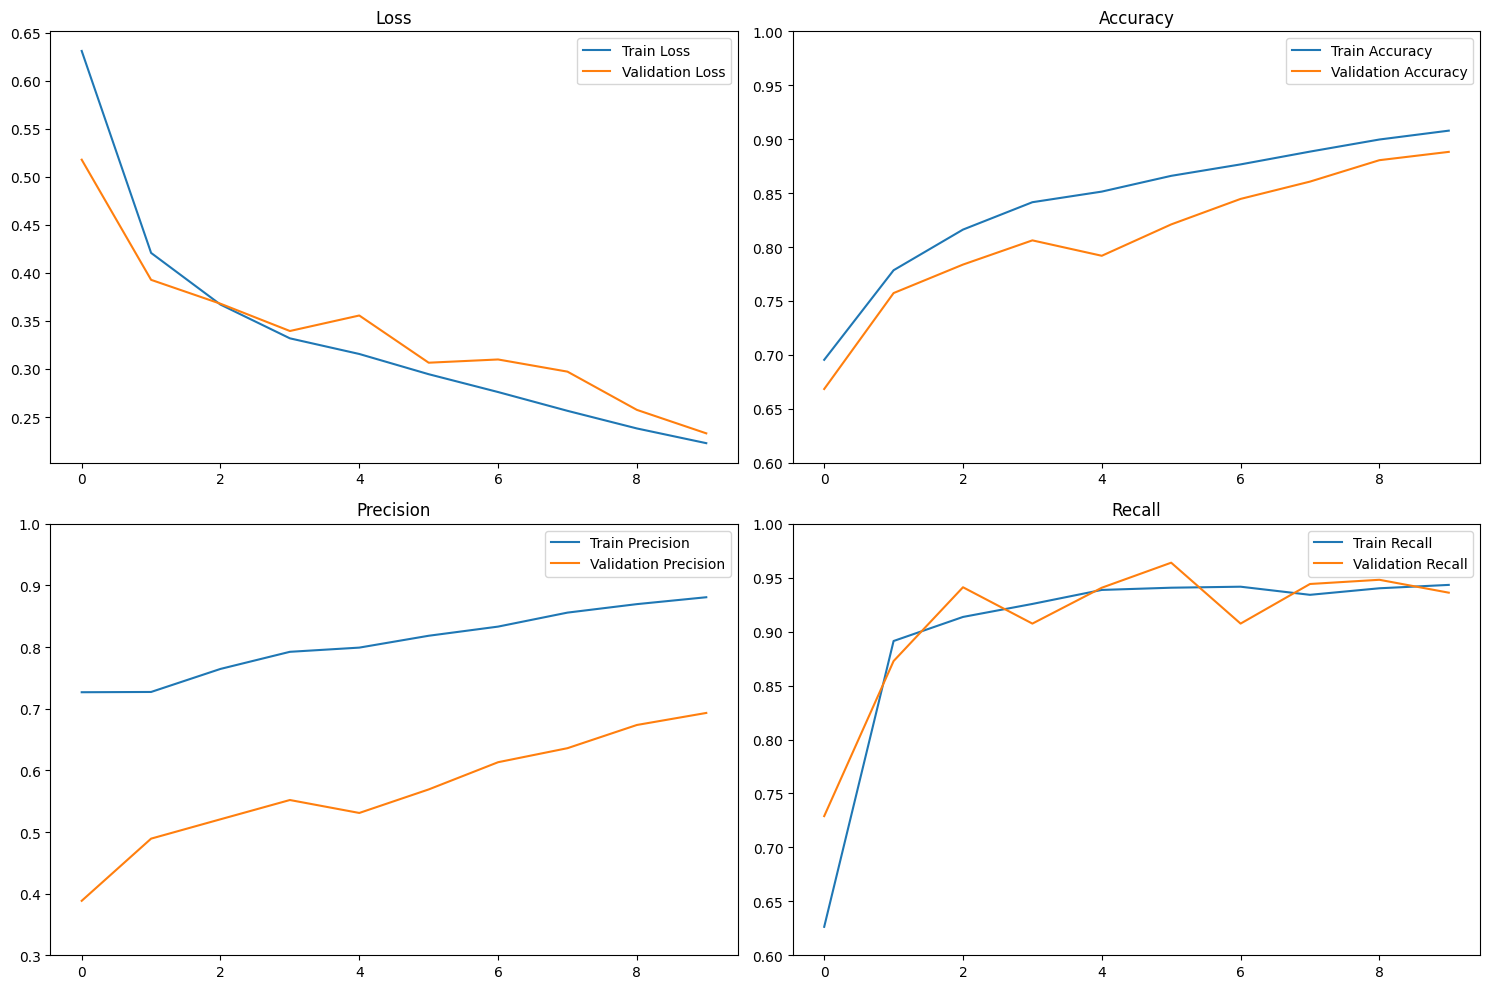

In [ ]:
import matplotlib.pyplot as plt

# Ваши данные
data = {'loss': [0.6310145854949951, 0.42080017924308777, 0.3670071065425873, 0.33188945055007935, 0.3156072497367859, 0.29455408453941345, 0.2759934663772583, 0.256435751914978, 0.23809798061847687, 0.22277946770191193], 'accuracy': [0.6954518556594849, 0.7785071730613708, 0.816193163394928, 0.8415760397911072, 0.8514145612716675, 0.8660210967063904, 0.8766329288482666, 0.8884918093681335, 0.8997058272361755, 0.9079188704490662], 'precision': [0.7267777919769287, 0.7272190451622009, 0.764603853225708, 0.7923663258552551, 0.7991730570793152, 0.8184139132499695, 0.8332566618919373, 0.8559626936912537, 0.8697245717048645, 0.8809016346931458], 'recall': [0.6263844966888428, 0.8913677334785461, 0.9136772751808167, 0.9257336258888245, 0.9387244582176208, 0.9407777190208435, 0.9417122602462769, 0.9341835975646973, 0.9402512907981873, 0.9433838129043579], 'val_loss': [0.5178220272064209, 0.3927692770957947, 0.3679160177707672, 0.33952033519744873, 0.3556574583053589, 0.3065263628959656, 0.3098936676979065, 0.2972286641597748, 0.25743600726127625, 0.2330092489719391], 'val_accuracy': [0.6683801412582397, 0.7573463916778564, 0.7837569713592529, 0.8062009215354919, 0.7919129133224487, 0.8209949135780334, 0.8446328639984131, 0.8606815934181213, 0.8805350661277771, 0.8882457613945007], 'val_precision': [0.3883737027645111, 0.48924705386161804, 0.5206477046012878, 0.5519039630889893, 0.530912458896637, 0.569069504737854, 0.6132373809814453, 0.6360030174255371, 0.6736401915550232, 0.6931709051132202], 'val_recall': [0.7290205359458923, 0.8727807998657227, 0.941196858882904, 0.9075084328651428, 0.9407638311386108, 0.963973343372345, 0.9075084328651428, 0.944227933883667, 0.9481250643730164, 0.9361739158630371]}
# Создание фигуры и осей
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# График Loss
axs[0, 0].plot(data['loss'], label='Train Loss')
axs[0, 0].plot(data['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Loss')
axs[0, 0].legend()

# График Accuracy
axs[0, 1].plot(data['accuracy'], label='Train Accuracy')
axs[0, 1].plot(data['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_ylim([0.6, 1])  # Установка верхней границы оси Y равной 1
axs[0, 1].legend()

# График Precision
axs[1, 0].plot(data['precision'], label='Train Precision')
axs[1, 0].plot(data['val_precision'], label='Validation Precision')
axs[1, 0].set_title('Precision')
axs[1, 0].set_ylim([0.3, 1])  # Установка верхней границы оси Y равной 1
axs[1, 0].legend()

# График Recall
axs[1, 1].plot(data['recall'], label='Train Recall')
axs[1, 1].plot(data['val_recall'], label='Validation Recall')
axs[1, 1].set_title('Recall')
axs[1, 1].set_ylim([0.6, 1])  # Установка верхней границы оси Y равной 1
axs[1, 1].legend()

# Отображение графиков
plt.tight_layout()
plt.show()